In [531]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from pathlib import Path
pd.set_option('display.max_columns', None)

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [532]:
DATA_PATH = Path('')

# Load files
train = pd.read_csv(DATA_PATH / 'Train.csv')
test = pd.read_csv(DATA_PATH / 'Test.csv')
sample_submission = pd.read_csv(DATA_PATH / 'SampleSubmission.csv')

In [533]:
null_values_total = train.isnull().sum().sum()
print(null_values_total)

252565


In [534]:
# Preview the first five rows of the sample submission file
sample_submission.head()

,id,pm2_5
0,id_ihxgrbq8bw,0
1,id_dg6s4fhiwe,0
2,id_f7hwwtmuzp,0
3,id_ioese5awdg,0
4,id_hdw320zpls,0


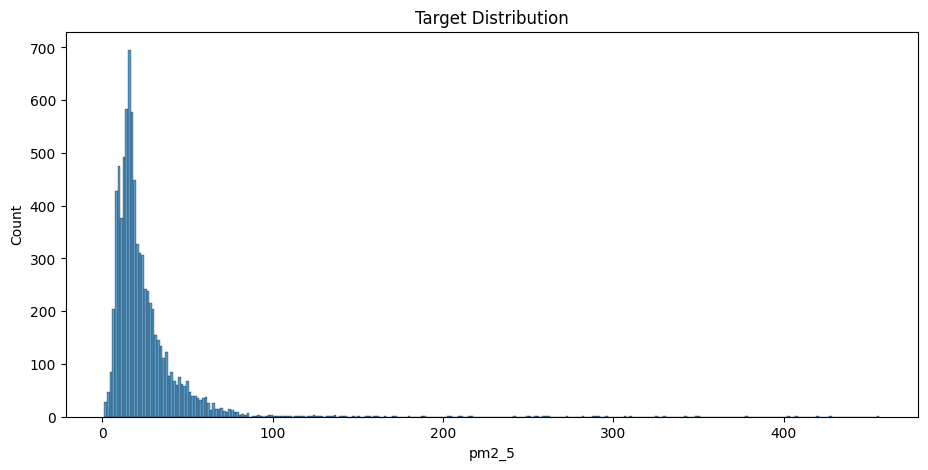

In [535]:
# target distribution
plt.figure(figsize = (11, 5))
sns.histplot(train.pm2_5)
plt.title('Target Distribution')
plt.show()

- From the target distribution histogram we can see that the distribution is skewed to the right.
- Some processing of the target is recommended

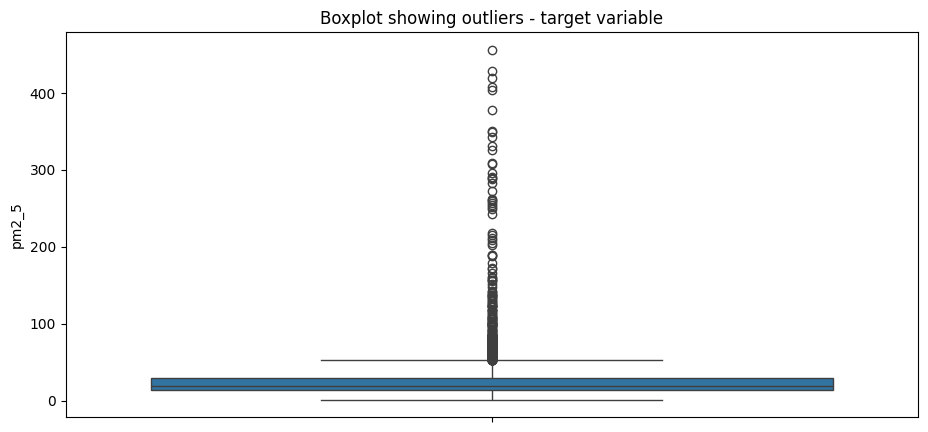

In [536]:
# Check for outliers in the target variable
plt.figure(figsize = (11, 5))
sns.boxplot(train.pm2_5)
plt.title('Boxplot showing outliers - target variable')
plt.show()

In [537]:
import pandas as pd
from scipy.stats.mstats import winsorize

# Basically what i did is limit remove the 3% of data that represnts the extreme data values (outliers) for the pm2_5 attribute
winsor_percentile = 3

# Winsorize the PM2.5 column to handle outliers
train['pm2_5'] = winsorize(train['pm2_5'], limits=(winsor_percentile/100., winsor_percentile/100.))


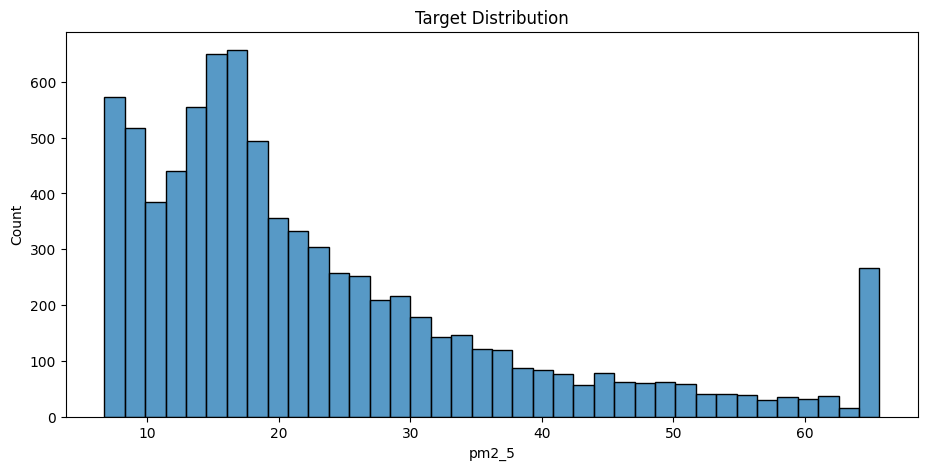

In [538]:
# target distribution
plt.figure(figsize = (11, 5))
sns.histplot(train.pm2_5)
plt.title('Target Distribution')
plt.show()

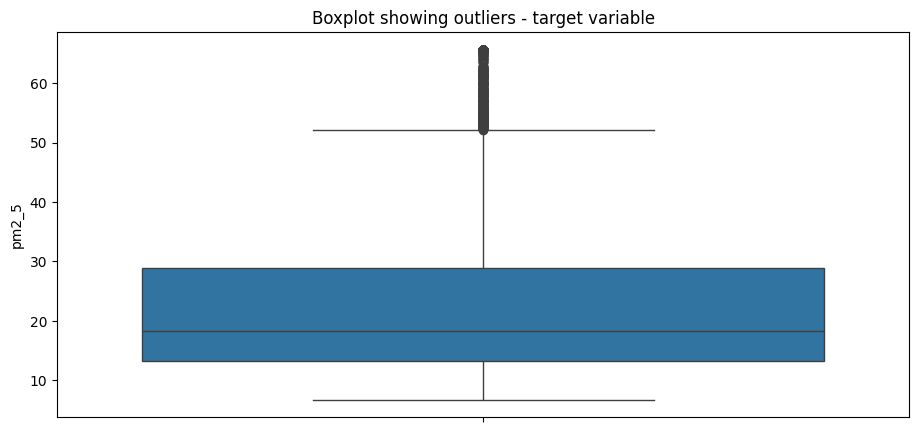

In [539]:
# Check for outliers in the target variable
plt.figure(figsize = (11, 5))
sns.boxplot(train.pm2_5)
plt.title('Boxplot showing outliers - target variable')
plt.show()


In [540]:

train = train.sort_values(by=['city','date'])
train.head()

,id,site_id,site_latitude,site_longitude,city,country,date,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,uvaerosollayerheight_aerosol_height,uvaerosollayerheight_aerosol_pressure,uvaerosollayerheight_aerosol_optical_depth,uvaerosollayerheight_sensor_zenith_angle,uvaerosollayerheight_sensor_azimuth_angle,uvaerosollayerheight_solar_azimuth_angle,uvaerosollayerheight_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5
7946,id_kckponblua,64ef31227771f10013f8b066,-3.38065,29.38383,Bujumbura,Burundi,2023-11-04,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.685403,830141.437500,-100.412834,32.509525,-113.255730,33.186264,0.116598,2.374336,0.280684,228.055298,0.827587,-100.412834,32.509525,-113.255730,33.186264,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.827591,54901.082031,5134.122559,62186.304687,4134.122559,7.747695,0.334881,-100.412849,32.509655,-113.255730,33.186287,27.504000
7947,id_gshykfsukc,64ef31227771f10013f8b066,-3.38065,29.38383,Bujumbura,Burundi,2023-11-08,12,0.000053,0.834035,0.000044,0.272225,-98.194786,61.065216,-112.312523,39.292221,0.000085,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000053,0.00002,0.000034,0.000134,9580.895123,0.06455,0.067366,830285.155442,-98.203111,61.065073,-112.259267,39.282251,0.000047,1.265092,0.000001,0.343269,39.282251,-112.259267,61.065073,-98.203111,0.064541,830285.155442,-98.203111,61.065073,-112.259267,39.282251,0.115969,3.233901,0.377243,229.012628,0.348761,-98.203111,61.065073,-112.259267,39.282251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.272750
7948,id_aqxf9kcpqu,64ef31227771f10013f8b066,-3.38065,29.38383,Bujumbura,Burundi,2023-11-09,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.136

In [541]:
null_values_per_column = train.isnull().sum()

In [542]:
import pandas as pd
from datetime import timedelta

# Assuming your dataframe is named df


# First, make sure your date column is in datetime format
train['date'] = pd.to_datetime(train['date'])

# Sort the dataframe by city and date
train= train.sort_values(by=['city', 'date'])

# Function to calculate mean within 2 days range for a specific column
def fill_nan_mean_within_range(df,column_name, row):
    city = row['city']
    current_date = row['date']
    two_days_ago = current_date - timedelta(days=1)
    two_days_later = current_date + timedelta(days=1)
    relevant_rows = df[(df['city'] == city) & (df['date'] >= two_days_ago) & (df['date'] <= two_days_later)]
    mean_value = relevant_rows[column_name].mean()
    return mean_value

# Loop through each column containing NaN values
for column in train.columns[train.isna().any()]:
    train[column] = train.apply(lambda row: fill_nan_mean_within_range(train,column, row) if pd.isna(row[column]) else row[column], axis=1)


In [543]:
null_values_total = train.isnull().sum().sum()
print(null_values_total)

76610


In [544]:
null_values_total = train.isnull().sum().sum()
print(null_values_total)

76610


In [545]:


train_num_df = train.select_dtypes(include=['number'])
test_num_df =test.select_dtypes(include=['number'])

null_values_total = train_num_df.isnull().sum().sum()
print(null_values_total)


76610


In [546]:
# Select X and y features for modelling
train_num_df = train.select_dtypes(include=['number'])
test_num_df =test.select_dtypes(include=['number'])
X = train_num_df.drop('pm2_5', axis = 1)
y = train.pm2_5

test_df = test_num_df[X.columns]


In [547]:
X.head()

,site_latitude,site_longitude,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,uvaerosollayerheight_aerosol_height,uvaerosollayerheight_aerosol_pressure,uvaerosollayerheight_aerosol_optical_depth,uvaerosollayerheight_sensor_zenith_angle,uvaerosollayerheight_sensor_azimuth_angle,uvaerosollayerheight_solar_azimuth_angle,uvaerosollayerheight_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle
7946,-3.38065,29.38383,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.685403,830141.437500,-100.412834,32.509525,-113.255730,33.186264,0.116598,2.374336,0.280684,228.055298,0.827587,-100.412834,32.509525,-113.255730,33.186264,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.827591,54901.082031,5134.122559,62186.304687,4134.122559,7.747695,0.334881,-100.412849,32.509655,-113.255730,33.186287
7947,-3.38065,29.38383,12,0.000053,0.834035,0.000044,0.272225,-98.194786,61.065216,-112.312523,39.292221,0.000085,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000053,0.00002,0.000034,0.000134,9580.895123,0.06455,0.067366,830285.155442,-98.203111,61.065073,-112.259267,39.282251,0.000047,1.265092,0.000001,0.343269,39.282251,-112.259267,61.065073,-98.203111,0.064541,830285.155442,-98.203111,61.065073,-112.259267,39.282251,0.115969,3.233901,0.377243,229.012628,0.348761,-98.203111,61.065073,-112.259267,39.282251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,24209.783203,11304.898437,27750.964844,10304.898437,8.031931,0.345833,-99.661995,41.890026,-114.965317,35.046368
7948,-3.38065,29.38383,11,0.000053,0.834035,0.000044,0.272225,-98.194786,61.065216,-112.312523,39.292221,0.000085,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000053,0.00002,0.000034,0.000134,9580.895123,0.06455,0.067366,830285.155442,-98.203111,61.065073,-112.259267,39.282251,0.000047,1.265092,0.000001,0.343269,39.282251,-112.259267,61.065073,-98.203111,-0.136088,83020

In [548]:
X.shape

(8071, 74)

In [549]:
test_df.head()

,site_latitude,site_longitude,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,uvaerosollayerheight_aerosol_height,uvaerosollayerheight_aerosol_pressure,uvaerosollayerheight_aerosol_optical_depth,uvaerosollayerheight_sensor_zenith_angle,uvaerosollayerheight_sensor_azimuth_angle,uvaerosollayerheight_solar_azimuth_angle,uvaerosollayerheight_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle
0,5.61252,-0.22955,13,-0.000072,0.762543,-0.000055,0.079645,-100.330299,26.926420,-86.879776,25.512329,-0.000028,9.0,0.043537,2825.323242,1.000000,829406.9375,-97.787621,26.897718,-86.884308,25.509418,0.000055,0.000016,0.000040,0.000109,9582.745678,-0.258421,0.019749,829420.312500,-100.330299,26.926420,-86.879776,25.512329,0.000243,1.112240,0.000213,0.079645,25.512329,-86.879776,26.926420,-100.330299,-0.258422,829420.312500,-100.330299,26.926420,-86.879776,25.512329,0.126056,2.243713,0.286278,230.244171,0.079324,-100.330299,26.926420,-86.879776,25.512329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.043065,74217.403083,2710.544562,83569.504246,1710.544483,3.063105,0.263193,-100.317077,27.059646,-86.885670,25.530511
1,5.61252,-0.22955,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,0.036341,2604.788330,1584.809692,829328.6250,70.753090,11.428769,-87.764297,20.935318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.408162,829340.750000,76.400116,11.171532,-87.726566,20.951560,0.126282,2.136400,0.273757,230.184377,0.613266,76.400116,11.171532,-87.726566,20.951560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.61252,-0.22955,13,-0.000051,1.004265,-0.000051,0.163160,73.117264,43.112466,-89.089083,16.417355,-0.000023,9.0,0.037453,3046.314001,90.699029,829194.5625,71.272375,43.172868,-88.964294,16.440554,0.000062,0.000027,0.000036,0.000134,9582.743944,-0.115200,0.163328,829204.480816,73.117264,43.112466,-89.089083,16.417355,0.000145,1.345840,0.000127,

In [550]:
y.shape

(8071,)

In [551]:
test.shape

(2783, 79)

In [552]:
# Train model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

model = LGBMRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
    
rmse = mean_squared_error(y_test, y_pred, squared=False)
    
print(rmse)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17310
[LightGBM] [Info] Number of data points in the train set: 5649, number of used features: 74
[LightGBM] [Info] Start training from score 23.271903
6.887753051858174


In [553]:
# Make predictions on the test set
preds = model.predict(test_df)
# Create submission file
sub = pd.DataFrame({'id': test['id'], 'pm2_5': preds})
# Preview sub file
sub.head()

,id,pm2_5
0,id_ihxgrbq8bw,20.516943
1,id_dg6s4fhiwe,25.471526
2,id_f7hwwtmuzp,14.244803
3,id_ioese5awdg,21.294222
4,id_hdw320zpls,14.953936


In [554]:
# Create a csv file
sub.to_csv('submission.csv', index = False)